# **Анализ и прогнозирование многомерного временного ряда**

## Предобработка данных

**Загрузка библиотек:**

In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import STL

**Загрузка датасета:**

In [4]:
df = pd.read_excel('DataSet.xlsx')
df.sample(10)

,Unnamed: 0,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, млрд руб","М2, млрд руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
75,2017-04-01,NaN,8.655263,9.75,0.52,6.25,53.06,167.56887,7610.346801,38555.203677,56.43,39225
54,2015-07-01,185049.0,10.199130,11.50,2.20,8.74,55.87,152.07483,6659.495603,31936.293528,57.07,33901
77,2017-06-01,NaN,8.039048,9.00,0.71,5.70,46.89,169.21483,7813.342742,39222.853872,57.82,41454
39,2014-04-01,300439.0,7.447273,7.50,1.87,5.18,107.88,128.89632,6608.200000,29519.300000,35.66,32947
70,2016-11-01,172323.0,8.936190,10.00,0.72,6.62,46.44,164.75018,7339.148803,36051.043468,64.36,36195
78,2017-07-01,NaN,8.074286,9.00,0.66,6.07,48.50,169.33328,7946.920837,39623.111354,59.67,38073
50,2015-03-01,186618.0,12.795238,14.00,5.18,11.16,55.79,149.36949,6671.922719,31224.976954,60.23,32642
79,2017-08-01,NaN,7.882174,9.00,0.73,6.07,52.00,168.41888,8034.188296,39275.911028,59.65,37099
12,2012-01-01,-168795.0,6.411905,8.00,3.10,5.80,110.99,110.59088,5938.600000,24204.800000,31.51,23746
61,2016-02-01,269297.0,9.930476,11.00,1.62,7.68,33.20,159.47707,7055.140825,33966.453991,77.22,33873


**Переименование столбца с датами:**

In [5]:
df = df.rename(columns = {'Unnamed: 0': 'Дата'})

**Типы данных переменных:**

In [6]:
df.dtypes

Дата                                                 datetime64[ns]
Прирост вкладов физических лиц в рублях (млн руб)           float64
Доходность ОФЗ по сроку до 1 года                           float64
Ключевая ставка                                             float64
Ставка по вкладам в долларах до 1 года                      float64
Ставка по вкладам в рублях до 1 года                        float64
Нефть марки Юралс, долл./барр                               float64
Индекс потребительских цен, ед.                             float64
М0, млрд руб                                                float64
М2, млрд руб                                                float64
Курс доллара к рублю, руб                                   float64
Номинальная средняя з/п, руб                                  int64
dtype: object

**Задние индекса:**

In [7]:
df = df.set_index('Дата')
df.head()

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, млрд руб","М2, млрд руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
Дата,,,,,,,,,,,
2011-01-01,-79049.0,5.244667,7.75,2.9,4.5,96.29,106.17151,5062.7,20011.9,30.08,20669
2011-02-01,180475.0,5.144211,8.00,3.1,4.4,103.96,106.99964,4830.7,19307.7,29.29,20680
2011-03-01,106845.0,5.021364,8.00,3.1,4.2,114.44,107.66304,4898.0,19536.7,28.43,22673
2011-04-01,224890.0,4.558571,8.00,2.6,4.1,123.15,108.12599,4918.2,19788.7,28.10,22519
2011-05-01,45856.0,4.795000,8.25,2.6,4.1,114.46,108.64500,5071.3,20020.8,27.87,22779


**Размер датасета:**

In [8]:
df.shape

(84, 11)

**Пропущенные значения:**

In [9]:
df.isna().sum()

Прирост вкладов физических лиц в рублях (млн руб)    12
Доходность ОФЗ по сроку до 1 года                     0
Ключевая ставка                                       0
Ставка по вкладам в долларах до 1 года                0
Ставка по вкладам в рублях до 1 года                  0
Нефть марки Юралс, долл./барр                         0
Индекс потребительских цен, ед.                       0
М0, млрд руб                                          0
М2, млрд руб                                          0
Курс доллара к рублю, руб                             0
Номинальная средняя з/п, руб                          0
dtype: int64

In [10]:
df[df.isna().any(axis = 1)]

,Прирост вкладов физических лиц в рублях (млн руб),Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, млрд руб","М2, млрд руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб"
Дата,,,,,,,,,,,
2017-01-01,NaN,8.416190,10.00,0.79,6.50,54.89,166.434720,7714.777071,38417.973904,59.96,34422
2017-02-01,NaN,8.830526,10.00,0.77,6.30,55.49,166.800870,7543.682136,38016.827597,58.39,35497
2017-03-01,NaN,8.987727,9.75,0.80,5.91,51.97,167.017720,7587.379089,38462.292674,58.10,37899
2017-04-01,NaN,8.655263,9.75,0.52,6.25,53.06,167.568870,7610.346801,38555.203677,56.43,39225
2017-05-01,NaN,8.319500,9.25,0.76,6.10,50.87,168.188880,7775.286453,38663.774533,57.17,39679
2017-06-01,NaN,8.039048,9.00,0.71,5.70,46.89,169.214830,7813.342742,39222.853872,57.82,41454
2017-07-01,NaN,8.074286,9.00,0.66,6.07,48.50,169.333280,7946.920837,39623.111354,59.67,38073
2017-08-01,NaN,7.882174,9.00,0.73,6.07,52.00,168.418880,8034.188296,39275.911028,59.65,37099
2017-09-01,NaN,7.648095,8.50,0.66,5.31,57.00,168.166250,8066.772110,39419.314228,57.73,38047


Пропущенных значений, требующих замены перед анализом, не обнаружено.

**Визуализация переменных:**

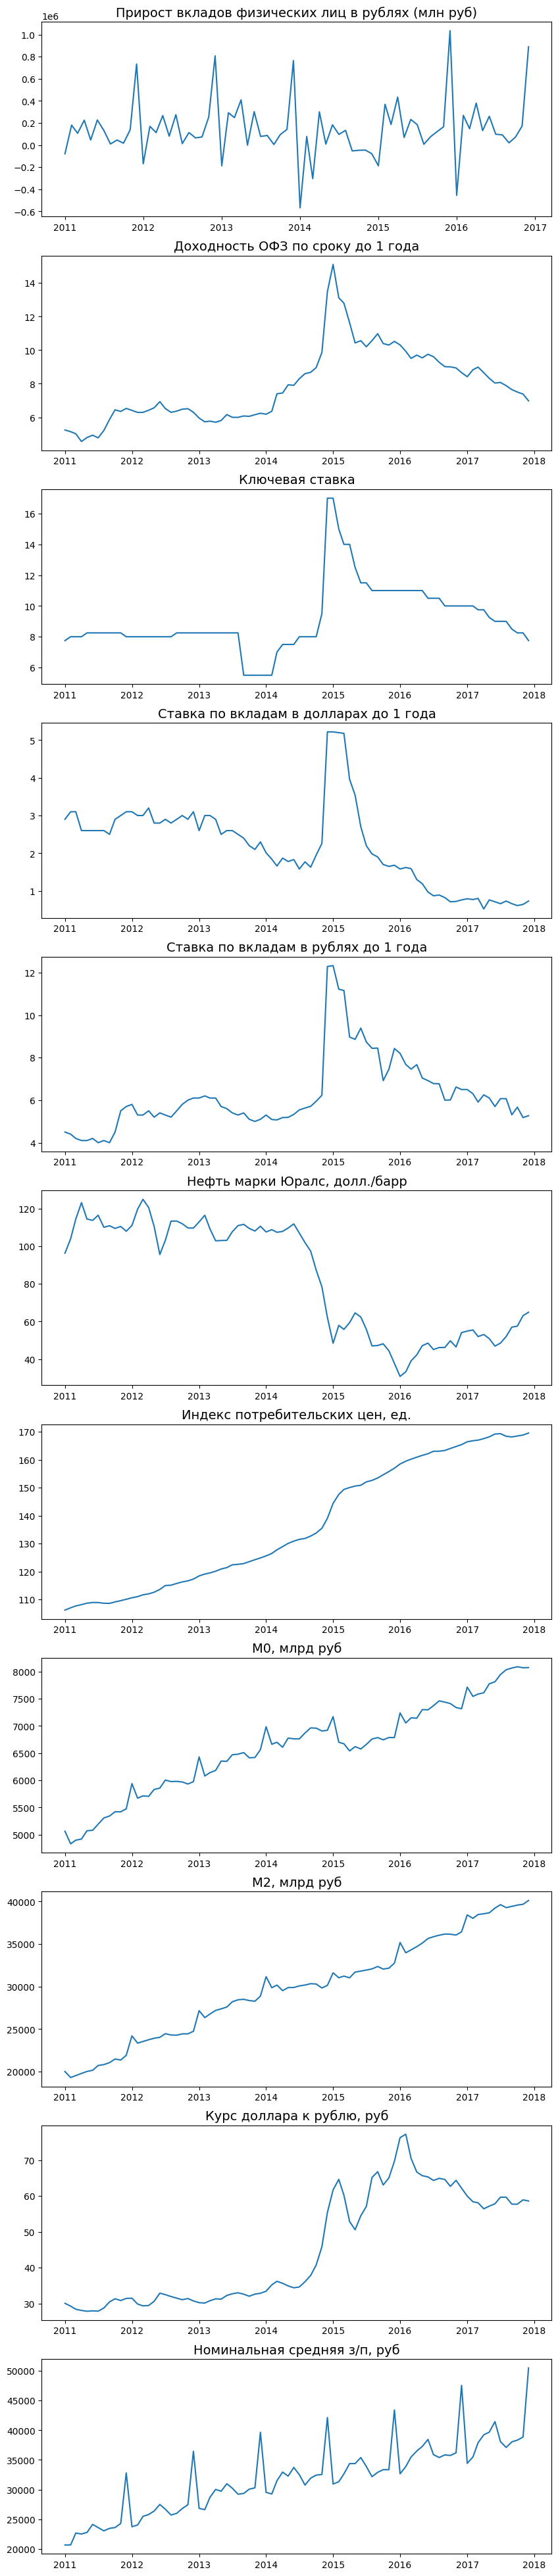

In [11]:
f, ax = plt.subplots(nrows = 11, ncols = 1, figsize = (10, 50))

for i, column in enumerate(df.columns):
    sns.lineplot(x = df.index, y = df[column], ax = ax[i])
    ax[i].set_title(df.columns[i], fontsize = 14)
    ax[i].set_ylabel(ylabel = '')
    ax[i].set_xlabel(xlabel = '')
plt.show()

В переменных наблюдается тренд и сезонность.

**Разделение датасета на X (предикторы) и y (целевая переменная):**

In [12]:
X = df.iloc[:, 1:]
y = df['Прирост вкладов физических лиц в рублях (млн руб)'][:72]

**Корреляция между переменными:**

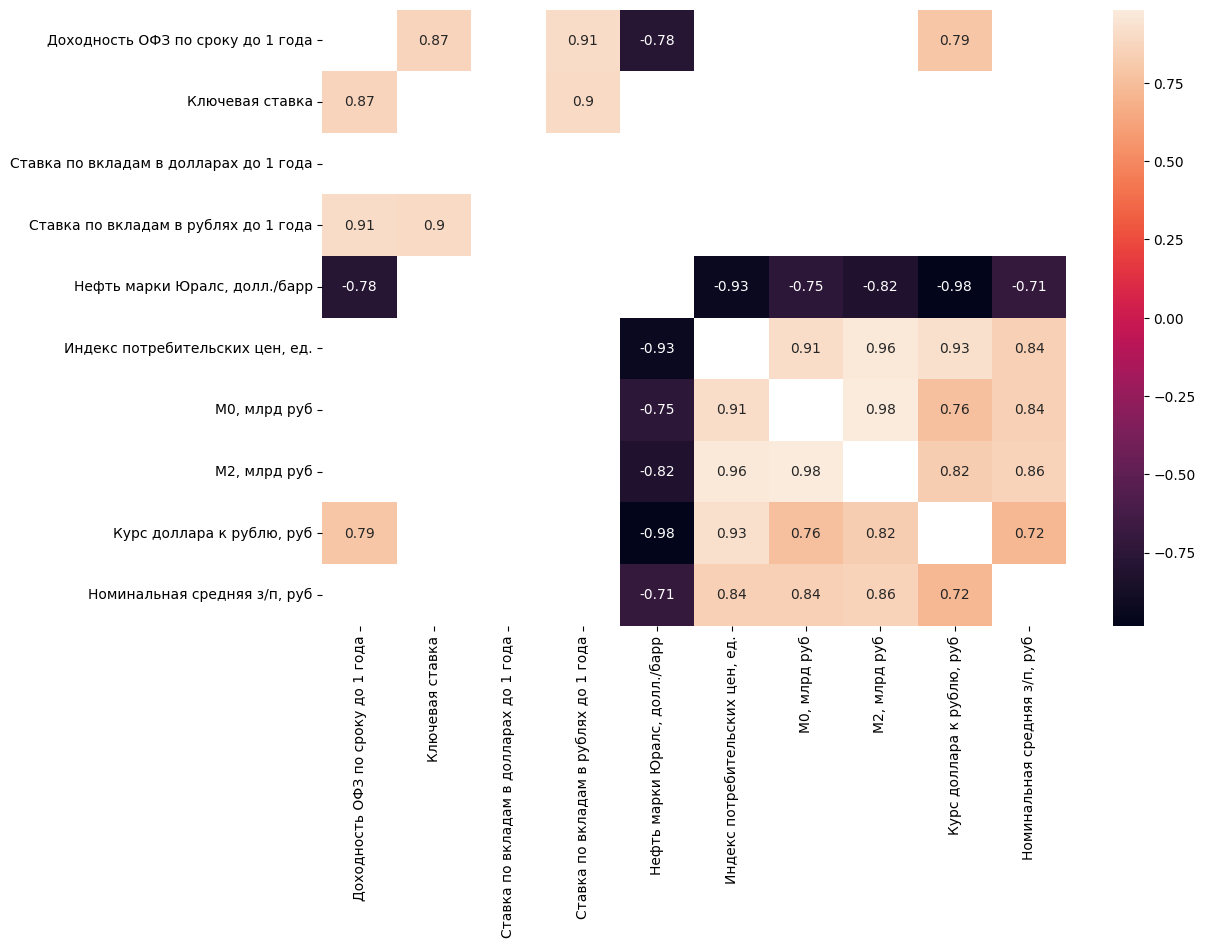

In [13]:
corr_matrix = X.corr()
high_corr_pairs = corr_matrix[(abs(corr_matrix) > 0.7) & (abs(corr_matrix) < 1)]
plt.figure(figsize = (12,8))
sns.heatmap(high_corr_pairs, annot = True)
plt.show()

**Декомпозиция переменных:**

In [14]:
def stl_decomposition(series, seasonal = 11):
    stl = STL(series, seasonal = seasonal)
    res = stl.fit()
    return {'observed': res.observed,
            'trend': res.trend,
            'seasonal': res.seasonal,
            'resid': res.resid}

decomposed_data = {}
for column in X.columns:
    decomposed_data[column] = stl_decomposition(X[column])

**Визуализация декомпозиции:**

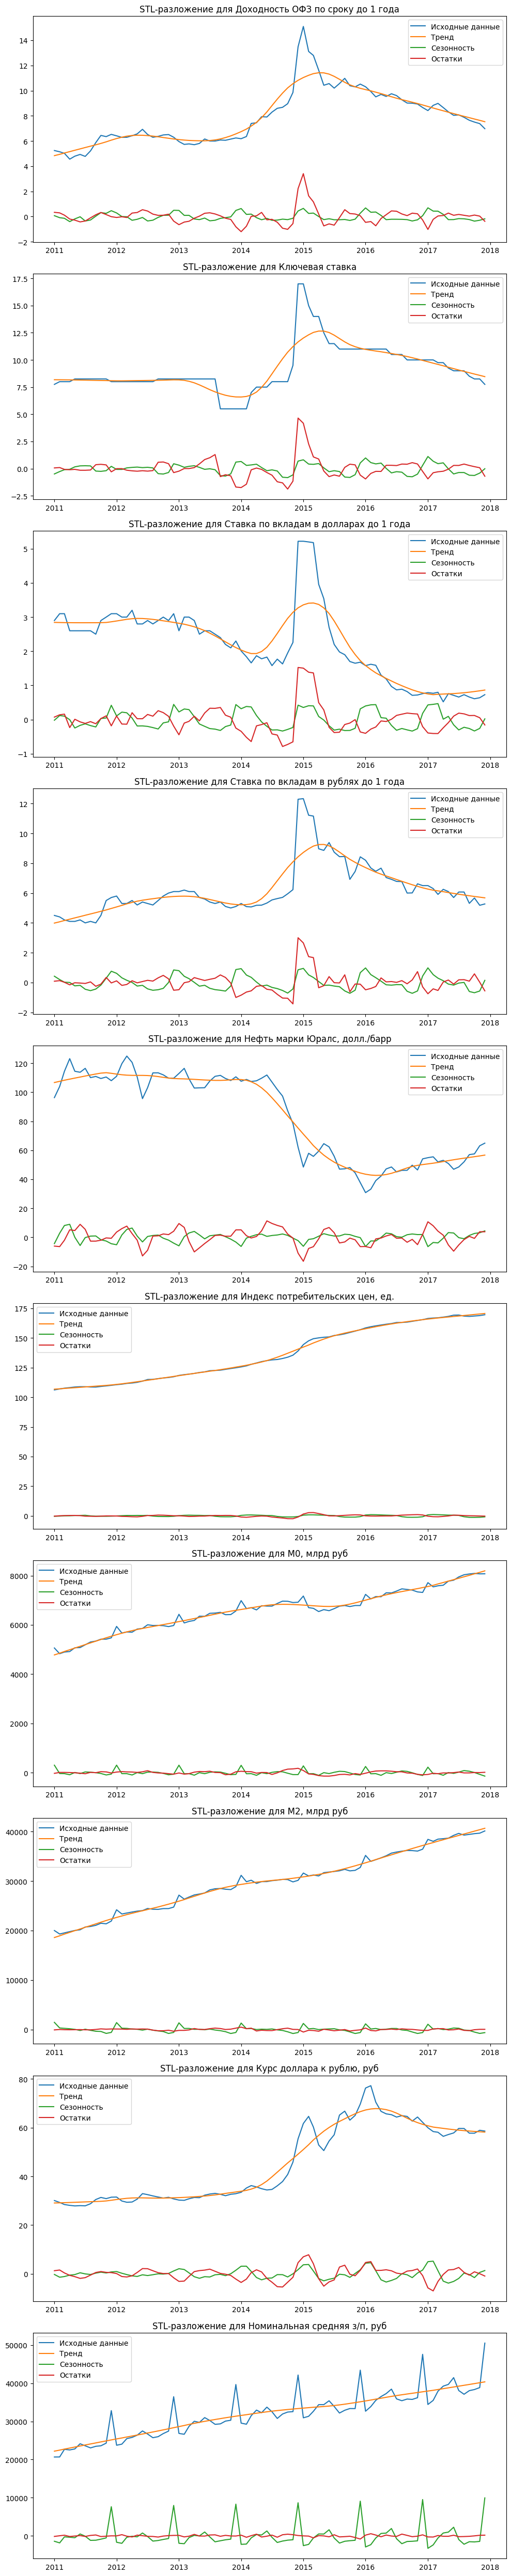

In [15]:
plt.figure(figsize = (10, 50))
for i, column in enumerate(X.columns):
    plt.subplot(10, 1, i + 1)
    plt.plot(decomposed_data[column]['observed'], label='Исходные данные')
    plt.plot(decomposed_data[column]['trend'], label='Тренд')
    plt.plot(decomposed_data[column]['seasonal'], label='Сезонность')
    plt.plot(decomposed_data[column]['resid'], label='Остатки')
    plt.title(f'STL-разложение для {column}')
    plt.legend()
plt.tight_layout()
plt.show()

**Удаление тренда и сезонности:**

In [16]:
def get_detrended_data(decomposed):
    return pd.DataFrame({column: decomposed[column]['resid'] for column in decomposed})

detrended_X = get_detrended_data(decomposed_data)

**Критерий Дики-Фуллера (проверка на стационарность):**

In [17]:
for i in detrended_X.columns:
    result = adfuller(detrended_X[i])
    print(f'\n{i}: p-value={result[1]}')


Доходность ОФЗ по сроку до 1 года: p-value=0.024428264308014522

Ключевая ставка: p-value=1.5921471910722305e-06

Ставка по вкладам в долларах до 1 года: p-value=1.2019781289276372e-05

Ставка по вкладам в рублях до 1 года: p-value=0.0047590979609934475

Нефть марки Юралс, долл./барр: p-value=4.14059127940015e-08

Индекс потребительских цен, ед.: p-value=0.00018198043983940547

М0, млрд руб: p-value=3.218065587346418e-05

М2, млрд руб: p-value=2.0126391290047167e-06

Курс доллара к рублю, руб: p-value=7.437620521351753e-12

Номинальная средняя з/п, руб: p-value=3.102161020406192e-06


Для всех переменных p < 0.05. Временной ряд стационарен.

**Создание лаговых переменных:**

In [18]:
lag_periods = [1, 2, 3]

for lag in lag_periods:
    for feature in detrended_X:
        detrended_X[f'{feature}_lag_{lag}'] = detrended_X[feature].shift(lag)

detrended_X.dropna(inplace = True)
detrended_X.shape

(78, 80)

**Создание скользящих средних:**

In [19]:
window_sizes = [3, 5, 7]

for window in window_sizes:
    for feature in detrended_X.iloc[:, :10]:
        detrended_X[f'{feature}_rolling_mean_{window}'] = detrended_X[feature].rolling(window = window).mean()

detrended_X.dropna(inplace = True)
detrended_X.shape

C:\Users\vist9\AppData\Local\Temp\ipykernel_4580\3087213667.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  detrended_X[f'{feature}_rolling_mean_{window}'] = detrended_X[feature].rolling(window = window).mean()


(72, 110)

**Создание сезонных переменных:**

In [20]:
detrended_X['month'] = detrended_X.index.month
detrended_X['year'] = detrended_X.index.year 
detrended_X.shape

C:\Users\vist9\AppData\Local\Temp\ipykernel_4580\3455097192.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  detrended_X['month'] = detrended_X.index.month
C:\Users\vist9\AppData\Local\Temp\ipykernel_4580\3455097192.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  detrended_X['year'] = detrended_X.index.year


(72, 112)

**Масштабирование данных:**

In [21]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(detrended_X), 
                        index = detrended_X.index, 
                        columns = detrended_X.columns)
X_scaled.head()

,Доходность ОФЗ по сроку до 1 года,Ключевая ставка,Ставка по вкладам в долларах до 1 года,Ставка по вкладам в рублях до 1 года,"Нефть марки Юралс, долл./барр","Индекс потребительских цен, ед.","М0, млрд руб","М2, млрд руб","Курс доллара к рублю, руб","Номинальная средняя з/п, руб",...,Ставка по вкладам в долларах до 1 года_rolling_mean_7,Ставка по вкладам в рублях до 1 года_rolling_mean_7,"Нефть марки Юралс, долл./барр_rolling_mean_7","Индекс потребительских цен, ед._rolling_mean_7","М0, млрд руб_rolling_mean_7","М2, млрд руб_rolling_mean_7","Курс доллара к рублю, руб_rolling_mean_7","Номинальная средняя з/п, руб_rolling_mean_7",month,year
Дата,,,,,,,,,,,,,,,,,,,,,
2012-01-01,-0.139205,-0.012269,0.237747,0.140202,0.634795,-0.147685,0.428953,0.676938,0.028152,0.005763,...,-0.114910,-0.020116,0.074256,-0.406171,0.225491,0.604122,0.031640,0.011680,-1.593255,-1.46385
2012-02-01,-0.054077,-0.009937,-0.294724,-0.291572,1.059547,-0.523820,0.709546,0.614008,-0.411046,1.285037,...,-0.125037,-0.073044,0.101995,-0.453138,0.525415,0.815446,0.082772,0.839431,-1.303572,-1.46385
2012-03-01,-0.145658,-0.152570,-0.305710,-0.203656,1.363197,-0.615483,0.521809,0.325663,-0.478648,-0.292788,...,-0.166377,-0.143390,0.642548,-0.505870,0.587938,0.957028,-0.001636,0.485004,-1.013890,-1.46385
2012-04-01,0.381391,-0.206519,0.454056,0.151491,0.453344,-0.847903,0.451211,0.752144,-0.303731,-1.110926,...,0.011280,0.007747,0.913976,-0.585954,0.682028,1.100802,-0.152089,-0.434782,-0.724207,-1.46385
2012-05-01,0.448367,-0.240150,0.055778,-0.047485,-0.348426,-0.955835,0.182174,0.565937,0.193958,0.811793,...,0.008585,0.042834,0.915955,-0.744277,0.575440,1.033419,-0.193631,0.231493,-0.434524,-1.46385


**Создание общего датасета с предикторами и целевой переменной:**

In [22]:
data = pd.merge(y, X_scaled, left_index = True, right_index = True)
data.shape

(60, 113)

**Подготовка выборок:**

In [23]:
tscv = TimeSeriesSplit(n_splits = 5)

for train_idx, test_idx in tscv.split(data):
    train_data = data.iloc[train_idx]
    test_data = data.iloc[test_idx]

**Визуализация выборок:**

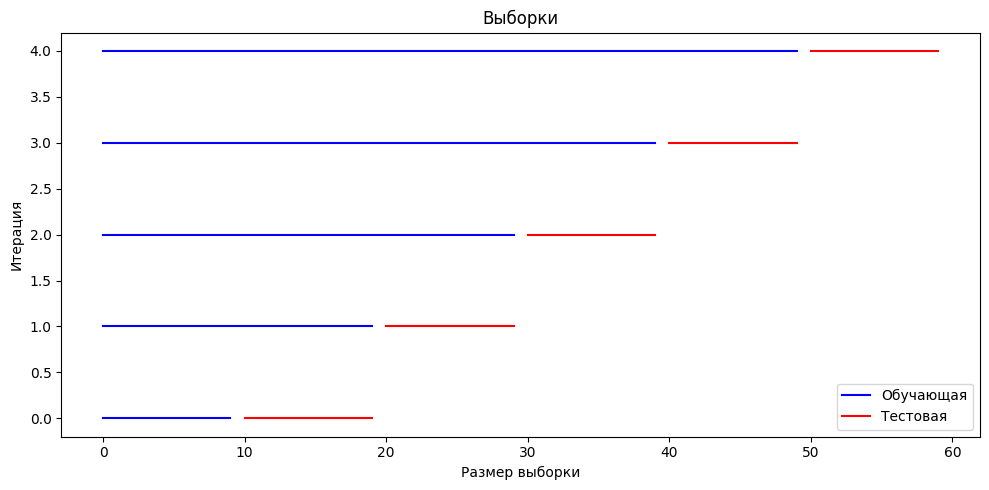

In [24]:
fig, ax = plt.subplots(figsize = (10, 5))
for i, (train_index, test_index) in enumerate(tscv.split(data)):
    ax.plot(train_index, [i] * len(train_index), 'b-', 
            label = 'Обучающая' if i == 0 else '')
    ax.plot(test_index, [i] * len(test_index), 'r-', 
            label = 'Тестовая' if i == 0 else '')
ax.set_title('Выборки')
ax.set_xlabel('Размер выборки')
ax.set_ylabel('Итерация')
ax.legend()
plt.tight_layout()
plt.show()

## Прогнозирование данных при помощи моделей VAR и XGBoost

**Обучение модели VAR:**

In [25]:
model_var = VAR(train_data)
model_var_fit = model_var.fit(maxlags = 12)

lag_order = model_var_fit.k_ar
steps = len(test_data)

forecast_values = model_var_fit.forecast(train_data.values[-lag_order:], 
                                         steps = steps)
forecast_df = pd.DataFrame(forecast_values, 
                           index = test_data.index, 
                           columns = train_data.columns)

c:\Users\vist9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Обучение модели XGBoost:**

In [26]:
X_train = train_data.drop('Прирост вкладов физических лиц в рублях (млн руб)', axis = 1)
y_train = train_data['Прирост вкладов физических лиц в рублях (млн руб)']
X_test = test_data.drop('Прирост вкладов физических лиц в рублях (млн руб)', axis = 1)
y_test = test_data['Прирост вкладов физических лиц в рублях (млн руб)']

model_xgb = xgb.XGBRegressor()
model_xgb.fit(X_train, y_train)

pred_xgb = model_xgb.predict(X_test)

**Сравнение моделей VAR и XGBoost на тестовых данных:**

In [27]:
mape_var = mean_absolute_percentage_error(y_test, forecast_df['Прирост вкладов физических лиц в рублях (млн руб)'])
mape_xgb = mean_absolute_percentage_error(y_test, pred_xgb)
r2_var = r2_score(y_test, forecast_df['Прирост вкладов физических лиц в рублях (млн руб)'])
r2_xgb = r2_score(y_test, pred_xgb)

print(f'MAPE VAR: {mape_var:.2f}%')
print(f'R2 VAR: {r2_var:.2f}')   
print(f'MAPE XGBoost: {mape_xgb:.2f}%')
print(f'R2 XGBoost: {r2_xgb:.2f}')

MAPE VAR: 2.23%
R2 VAR: -1.47
MAPE XGBoost: 0.84%
R2 XGBoost: 0.81


По результатам MAPE для прогнозирования выбрана модель XGBoost.

**Прогнозирование значений целевой переменной на 2017 год при помощи модели XGBoost:**

In [28]:
X_forecast = X_scaled[(X_scaled.index > '2016-12-01') & (X_scaled.index <= '2017-12-01')]
y_forecast = model_xgb.predict(X_forecast)

forecast_df = pd.DataFrame({'date': X_forecast.index, 'forecast': y_forecast})

**Создание общего датасета с исходными данными и прогнозом на 2017 год:**

In [29]:
all_data = pd.concat([pd.DataFrame({'date': y.index, 
                                    'value': y.values, 
                                    'type': 'Исходные данные'}),
                      pd.DataFrame({'date': X_forecast.index, 
                                    'value': y_forecast, 
                                    'type': 'Прогноз'})])

**Визуализация полученных данных:**

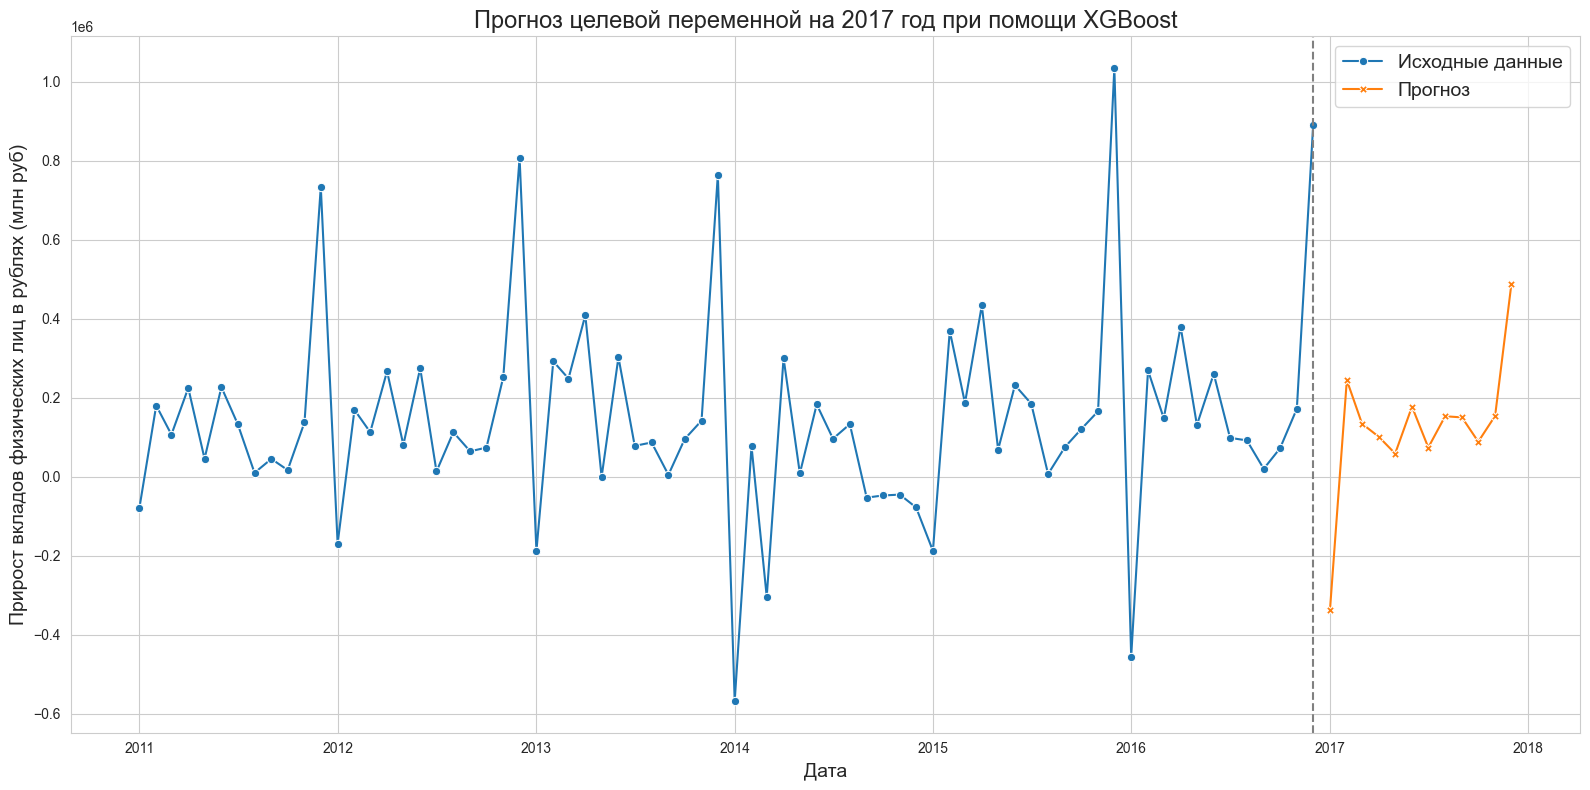

In [30]:
plt.figure(figsize = (16, 8))
sns.set_style('whitegrid')
sns.lineplot(data = all_data,
             x = 'date',
             y = 'value',
             hue = 'type',
             style = 'type',
             markers = True,
             dashes = False)
plt.title('Прогноз целевой переменной на 2017 год при помощи XGBoost', fontsize = 17)
plt.xlabel('Дата', fontsize = 14)
plt.ylabel('Прирост вкладов физических лиц в рублях (млн руб)', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid(True)
plt.tight_layout()
plt.axvline(x = pd.to_datetime('2016-12-01'), 
            color = 'gray', 
            linestyle = '--', 
            linewidth = 1.5)

plt.show()